High level story:

1. word cloud and barriers number histogram - what barriers do learners face? 
2. correlation, how do these barriers relate to each other? can we explore these relationships in more detail?
3. Likert diagrams to explore differences between programs/ regions, highlight interesting findings
4. visualise the flow of grads from bootcamp to 6months post-bootcamp. does placement speed vary per region? per programme? and how do the barriers factor in?

Questions for clarification: 
- what barriers/ metrics is the feature "barriers value" based on?

Other things to consider if there is time:
- create a boolean feature "Has special needs" to indicate if someone does have this recorded by their name or not. 

# Generation Exploratory Data Analysis
####   Megan Guidry | March 2024 

## Objective

#### The Dataset

- The original dataset has 2602 observations. Each observation represents a learner that has been admitted onto a Generation UK&I bootcamp.
- This analysis will focus on tech bootcamps. After removing non-tech bootcamps from the dataset there are 1917 observations.
- The original dataset included only one cohort of approximately 25 learners based in Dublin. The rest are based in the UK. I have removed the Dublin cohort from this analysis.
  
Program Names:
- Technology - Cloud Operations Engineer
- Technology - Data Engineering
- Data Analytics
- IT Support
- Tech Talent Accelerator - Software Engineering
- Google Cloud


- regions,
- feature names.

#### Questions 
- Q1
- Q2
- Q3

In [183]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from pandas.api.types import CategoricalDtype
from scipy import stats

## Data Cleaning

In [184]:
# Reading the data and combining the two data sources:
PowerBI_df = pd.read_csv("Gen_Data/data_improved_including DE_AWS.csv")
SF_df = pd.read_csv("Gen_Data/Grad_attendance_info.xls.csv")

SF_df.rename(columns={"Learner Name":"LearnerName"}, inplace=True) #renaming the column required for merging

gen_df = pd.merge(PowerBI_df, SF_df, left_on='LearnerName', right_on='LearnerName')

In [185]:
# Filter the data so that we are only looking at tech programmes:
gen_df = gen_df[gen_df["ProgramName"].isin(["Technology - Cloud Operations Engineer", 
                                                 "Technology - Data Engineering", 
                                                 "Data Analytics", "IT Support", 
                                                 "Tech Talent Accelerator - Software Engineering", 
                                                 "Google Cloud"])]

In [186]:
# Remove Dublin, this is the only Irish cohort and is an outlier in the dataset:
gen_df = gen_df.drop(gen_df[gen_df["Cohort_City"]=="Dublin"].index)

In [187]:
# Clean "learnerSpecialNeedsDetails" before creating a wordcloud:

Needs_clean = gen_df[["learnerSpecialNeedsDetails", "ProgramName"]].dropna()
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="No"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="NIL"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="Non"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="NONE"].index)
Needs_clean = Needs_clean.drop(Needs_clean[Needs_clean["learnerSpecialNeedsDetails"]=="nan"].index)

In [282]:
# replace nans in enrolment status with "Unknown"
# replace nans in employed within 90 days with 0

gen_df["Enrolment_Status"].fillna("Unknown", inplace=True)
gen_df["Employment_Status"].fillna("Unknown", inplace=True)

gen_df["Employed_within_90D"].fillna(0, inplace=True)
gen_df["Employed_within_90D_text"] = gen_df["Employed_within_90D"].replace(to_replace= [0, 1],
                                                                           value= ["Not employed 90D", "Employed 90D"])

gen_df["Employed_within_180D"].fillna(0, inplace=True)
gen_df["Employed_within_180D_text"] = gen_df["Employed_within_180D"].replace(to_replace= [0, 1],
                                                                           value= ["Not employed 180D", "Employed 180D"])


##### cleaning specific features ahead of heatmap correlation analysis

There are quite a lot of missing data in this dataset. for that reason I have carefully selected features that are as complete as possible to use for the correlation analysis. The features that were excluded from this portion of the EDA due to high numbers of NaN valuse include:

Features excluded from heatmap analysis due to large % of NaN:
- is_low_socio_econ
- is_unempl_12+_mths
- is_unemployed_pre_gen
- Job_start_speed
- socioeconStatusMap - needs ordinality assigned
- Average Score - Soft Skills
- Average Score - Technical Skills

Features included:
- asylumSeeker*
- Barriers value
- Education level
- has_degree
- Has_dependents*
- IMD_decile*
- Is_30_or_over
- Is_disabled
- is_EAL
- is_ethnic_minority*
- is_LGBTQ+*
- is_lone_parent*
- Days Since Cohort Graduation
- Total Days Absent
- Total Days Late

The features that have a star need data imputed. For most of these features (asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ, is_lone_parent) replaceing a null value with 0 is sufficient. This is because assigning a value of zero is equivalent to assuming this individual does not have this barrier. The error and bias from incorrectly lableing someone as having the barrier is greater than if we incorrectly lable someone as lacking the barrier. Aditionally, removing the rows completely would remove valuable data from other columns.

Data imputation for the feature IMD_decile will be handled separately.

In [188]:
# cleaning specific features ahead of heatmap correlation analysis:
# asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ+, is_lone_parent

# Cleaning asylumSeeker:
gen_df["asylumSeeker"].fillna(0, inplace=True)

# Cleaning Has_dependents:
gen_df["Has_dependents"].fillna(0, inplace=True)

# Cleaning is_ethnic_minority
gen_df["is_ethnic_minority"].fillna(0, inplace=True)

# Cleaning is_LGBTQ+
gen_df["is_LGBTQ+"].fillna(0, inplace=True)

# Cleaning is_lone_parent
gen_df["is_lone_parent"].fillna(0, inplace=True)


## Exploratory Data Analysis

#### What barriers do Generation UK & I learners face?

In this analysis we look specifically into 15 different situational or demographic barriers:
-   asylumSeeker                            
-   Education level                         
-   gender                                  
-   has_degree                              
-   Has_dependents                          
-   IMD_decile                              
-   Is_30_or_over                           
-   Is_disabled                            
-   is_EAL                                 
-   is_ethnic_minority                      
-   is_LGBTQ+                               
-   is_lone_parent                         
-   is_low_socio_econ                       
-   is_unempl_12+_mths                      
-   is_unemployed_pre_gen

NOTE: The feature "Barriers value" is a count of all the barriers metrics that describe an individual learner.            

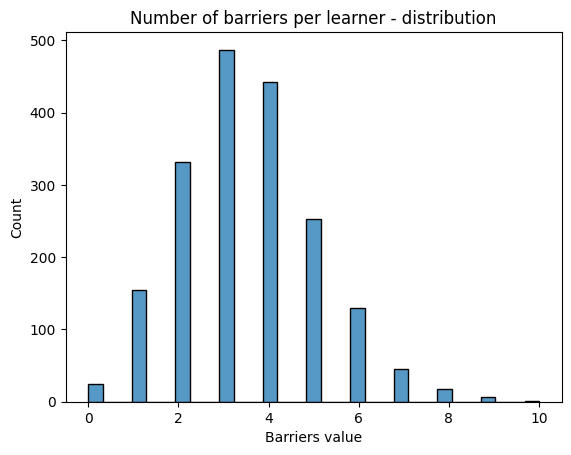

In [189]:
sns.histplot(data= gen_df, 
             x="Barriers value"
            )

plt.title("Number of barriers per learner - distribution")
plt.show()

#### What special needs are most common among learners
The feature learnerSpecialNeedsDetails captures important information about the special needs that particular grad has. This is recorded by a generation staff member during the admissions process and helps staff understand how best to support this individual.

Note: Most learners do not have any special needs so this data is reflecting the minority that have disclosed this information to Generation.

In [190]:
# Learner special needs wordcloud:
@interact
def wordcloud_by_programme(Prog_name=Needs_clean["ProgramName"].value_counts().index.tolist()):
    text = " ".join(i for i in Needs_clean["learnerSpecialNeedsDetails"][Needs_clean["ProgramName"]==Prog_name].astype(str))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('IT Support', 'Technology - Data Engineering'…

#### How do these barriers correlate with each other and with other learner fetures?

I will create a heatmap for visualising the relationships that exist between the barriers metrics. Before creating a heatmap in python there are three things I need to consider:
1. Handle missing data
2. remove outliers that may skew the results
3. assign ordinality to my categorical data where necessary 

##### Preparing my data for the heatmap

In [191]:
# Assigning ordinality to categorical features:

socioeconStatusMap_levels = CategoricalDtype(categories=["Exclude", "Lower socio-economic backgrounds", "Intermediate backgrounds", "Professional backgrounds"], ordered=True)
gen_df["socioeconStatusMap_ordered"] = gen_df["socioeconStatusMap"].astype(socioeconStatusMap_levels)

asylumSeeker_levels = CategoricalDtype(categories=["No", "Choose not to say", "Yes"], ordered=True)
gen_df["asylumSeeker_ordered"] = gen_df["asylumSeeker"].astype(asylumSeeker_levels)


In [192]:
# Fill the NaN values for the feature IMD_decile:


In [193]:
# selecting the columns wanted for the heatmap and creating a df.

heatmap_df = gen_df[['asylumSeeker_ordered', 
                     'Barriers value',
                     'Education level',
                     'has_degree', 
                     'Has_dependents',
                     'IMD_decile',
                     'Is_30_or_over', 
                     'Is_disabled', 
                     'is_EAL', 
                     'is_ethnic_minority',
                     'is_LGBTQ+', 
                     'is_lone_parent', 
                     'Days Since Cohort Graduation',
                     'Total Days Absent', 
                     'Total Days Late',
                    ]]

In [196]:
isnull_temp = gen_df[['asylumSeeker_ordered',
                     'Barriers value',
                     'Education level',
                     'has_degree', 
                     'Has_dependents',
                     'IMD_decile',
                     'Is_30_or_over', 
                     'Is_disabled', 
                     'is_EAL', 
                     'is_ethnic_minority',
                     'is_LGBTQ+', 
                     'is_lone_parent', 
                     'Days Since Cohort Graduation',
                     'Total Days Absent', 
                     'Total Days Late',
                    ]].isnull().groupby(gen_df["Cohort_name"]).sum()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
isnull_temp

,asylumSeeker_ordered,Barriers value,Education level,has_degree,Has_dependents,IMD_decile,Is_30_or_over,Is_disabled,is_EAL,is_ethnic_minority,is_LGBTQ+,is_lone_parent,Days Since Cohort Graduation,Total Days Absent,Total Days Late
Cohort_name,,,,,,,,,,,,,,,
AWS BIR 1,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWS BIR 2,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWS LEE1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AWS LON1,21,0,0,0,0,3,0,0,0,0,0,0,0,0,0
AWS LON2,21,0,0,0,0,2,0,0,0,0,0,0,0,0,0
AWS LON3,21,0,0,0,0,3,0,0,0,0,0,0,0,0,0
AWS LON4,25,0,0,0,0,2,0,0,0,0,0,0,0,0,0
AWS LON5,26,0,0,0,0,3,0,0,0,0,0,0,0,0,0
AWS LON6,22,0,0,0,0,2,0,0,0,0,0,0,0,0,0


In [ ]:
# Extracting column names from the heatmap df
column_names=heatmap_df.columns

# Assiging column names to row indexs to create the matrix
chisqmatrix=pd.DataFrame(heatmap_df,columns=column_names,index=column_names)

In [ ]:
# Setting counters to zero
outercnt=0
innercnt=0

for icol in column_names: # Outer loop
    for jcol in column_names: # inner loop
         # Converting to cross tab as for CHi-square test we have
         # to first convert variables into contigency table
         mycrosstab=pd.crosstab(heatmap_df[icol],heatmap_df[jcol])
        
         #Getting p-value and other usefull information
         stat,p,dof,expected=stats.chi2_contingency(mycrosstab)
        
         # Rounding very small p-values to zero
         chisqmatrix.iloc[outercnt,innercnt]=round(p,5)
        
         # As mentioned above Expected frequencies should be at 
         # least 5 for the majority (80%) of the cells.
         # Here we are checking expected frequency of each group
         cntexpected=expected[expected<5].size

         #Getting percentage 
         perexpected=((expected.size-cntexpected)/expected.size)*100

In [ ]:
if perexpected<20:
    chisqmatrix.iloc[outercnt,innercnt]=2 #Assigning 2
 
if icol==jcol:
    chisqmatrix.iloc[outercnt,innercnt]=0.00
    innercnt=innercnt+1
    outercnt=outercnt+1
    innercnt=0

#### Are there program-specific or region-specific trends in these barriers and their impact on placement outcomes?

#### does placement speed vary per region? per programme? and how do the barriers factor in?

In [199]:
def Sankey_data_preprocessing(source_feature, target_feature, data):
    source_ = [] 
    target_ = [] 
    value_ = []
    
    
    # Create a list of sources and a list of targets
    source_values_str = data[source_feature].value_counts().index.tolist()
    target_values_str = data[target_feature].value_counts().index.tolist()

    # Create a key value pair which can be used to transform the source and target strings into an int.
    source_keys = {x:source_values_str.index(x) for x in source_values_str}
    target_keys = {x:(target_values_str.index(x) + len(source_values_str)) for x in target_values_str}
    
    for source_val in source_values_str:
        for target_val in target_values_str:
            count_temp = data[data[target_feature]==target_val].groupby(data[source_feature]==source_val)[target_feature].count()
            if True in count_temp:
                count_temp = count_temp[True]
                source_.append(source_keys[source_val])
                target_.append(target_keys[target_val])
                value_.append(count_temp)

    return source_, target_, value_

In [201]:
source_, target_, value_ = Sankey_data_preprocessing("is_EAL", "Employment_Status", gen_df[gen_df["ProgramName"] == "IT Support"])

In [209]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ['Not EAL', 'EAL', 'Employed', 'Unemployed', 'Opted Out', 'Unknown', 'Internship'],
      color = "blue"
    ),
    link = dict(
      source = source_,
      target = target_,
      value = value_,
      # hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
  ))])

fig.update_layout(title_text="Basic Sankey Diagram for IT Support Programme", font_size=10)
fig.show(renderer="iframe") 

In [207]:
gen_df["is_EAL"].value_counts()

is_EAL
0    1221
1     671
Name: count, dtype: int64

In [208]:
gen_df["Employment_Status"].value_counts()

Employment_Status
Employed      821
Unemployed    582
Opted Out     133
Unknown        25
Placed          8
Internship      2
Name: count, dtype: int64

In [232]:
gen_df["Employed_within_90D"].value_counts()

Employed_within_90D
0.0    1145
1.0     426
Name: count, dtype: int64

In [ ]:
# Tidy/ refactor the code above:

In [266]:
def Sankey_data_preprocessing(source_feature, target_feature, data):
    source_ = [] 
    target_ = [] 
    value_ = []
    
    # Create a list of sources and a list of targets
    source_values_str = data[source_feature].value_counts().index.tolist()
    target_values_str = data[target_feature].value_counts().index.tolist()
    labels = source_values_str + target_values_str

    # Create a key value pair which can be used to transform the source and target strings into an int.
    source_keys = {x:source_values_str.index(x) for x in source_values_str}
    target_keys = {x:(target_values_str.index(x) + len(source_values_str)) for x in target_values_str}
    
    for source_val in source_values_str:
        for target_val in target_values_str:
            count_temp = data[data[target_feature]==target_val].groupby(data[source_feature]==source_val)[target_feature].count()
            if True in count_temp:
                count_temp = count_temp[True]
                source_.append(source_keys[source_val])
                target_.append(target_keys[target_val])
                value_.append(count_temp)

    return source_, target_, value_, labels

In [213]:
# Create a function for plotting the sankey diagram once data preprocessing is complete

def Sankey_plot(source_, target_, value_, labels=None, title_text_=None):
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = source_,
          target = target_,
          value = value_,
          # hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
      ))])
    
    fig.update_layout(title_text=title_text_, font_size=10)
    fig.show(renderer="iframe") 

In [224]:
gen_df[gen_df["ProgramName"] == "IT Support"]["Enrolment_Status"].value_counts()

Enrolment_Status
Graduated    226
Dropout       39
No Show       20
Dismissed      5
Name: count, dtype: int64

In [273]:
# Creating a more complicated Sankey diagram:
source_, target_, value_, labels = Sankey_data_preprocessing("Enrolment_Status", "Employed_within_90D_text", gen_df[gen_df["ProgramName"] == "IT Support"])

In [274]:
print(source_)
print(target_)
print(value_)
print(labels)

[0, 0, 1, 2, 3, 4]
[5, 6, 5, 5, 5, 5]
[140, 86, 39, 27, 20, 5]
['Graduated', 'Dropout', 'Unknown', 'No Show', 'Dismissed', 'Not employed 90D', 'Employed 90D']


In [275]:
Sankey_plot(source_, target_, value_, labels=labels, title_text_=None)

In [276]:
source_values_str = gen_df[gen_df["ProgramName"] == "IT Support"]["Enrolment_Status"].value_counts().index.tolist()
source_values_str

['Graduated', 'Dropout', 'Unknown', 'No Show', 'Dismissed']

In [277]:
source_keys = {x:source_values_str.index(x) for x in source_values_str}
source_keys

{'Graduated': 0, 'Dropout': 1, 'Unknown': 2, 'No Show': 3, 'Dismissed': 4}

In [280]:
target_values_str = gen_df[gen_df["ProgramName"] == "IT Support"]["Employed_within_90D_text"].value_counts().index.tolist()
target_values_str

['Not employed 90D', 'Employed 90D']

In [281]:
target_keys = {x:(target_values_str.index(x) + len(source_values_str)) for x in target_values_str}
target_keys

{'Not employed 90D': 5, 'Employed 90D': 6}

In [243]:
gen_df["Employed_within_90D"].isna().sum()

321

In [244]:
gen_df["is_EAL"].isna().sum()

0

In [245]:
gen_df["Employment_Status"].isna().sum()

321

In [264]:
gen_df["Employment_Status"].isna().sum()

321

In [283]:
# Creating a more complicated Sankey diagram:
source_, target_, value_, labels = Sankey_data_preprocessing("Employed_within_90D_text", "Employed_within_180D_text", gen_df[gen_df["ProgramName"] == "IT Support"])

In [284]:
Sankey_plot(source_, target_, value_, labels=labels, title_text_=None)

In [286]:
# Creating a more complicated Sankey diagram:
source_, target_, value_, labels = Sankey_data_preprocessing("Employed_within_180D_text", "Employment_Status", gen_df[gen_df["ProgramName"] == "IT Support"])

In [287]:
Sankey_plot(source_, target_, value_, labels=labels, title_text_=None)

In [345]:
def Sankey_data_preprocessing(feature_list, data):
    # replace with feature_list
    
    source_ = [] 
    target_ = [] 
    value_ = []
    int_keys = {}
    temp_list = []
    
    # Create a complete list of sources and targets and convert to a dict:
    for x in feature_list:
        temp_list += gen_df[x].value_counts().index.tolist()

    for x in temp_list:
        int_keys[x] = temp_list.index(x)

    # Keep track of the source and target strings
    source_values_str = []
    target_values_str = []

    # Keep track of the complete list of source and target strings
    source_str = []
    target_str = []

    # Loop through each source feature in the provided list source_feature_list. 
    # Each loop represents one portion of the sanksey diagram:
    
    for i in range(len(feature_list)-1):
        # Make a list of the source values and target values for this part of the sankey diagram:
        source_values_str = data[feature_list[i]].value_counts().index.tolist()
        target_values_str = data[feature_list[i+1]].value_counts().index.tolist()

# fix the reference to target feature
        for source_val in source_values_str:
            for target_val in target_values_str:
                count_temp = data[data[feature_list[i+1]]==target_val].groupby(data[feature_list[i]]==source_val)[feature_list[i+1]].count()
                if True in count_temp:
                    count_temp = count_temp[True]
                    source_.append(int_keys[source_val])
                    target_.append(int_keys[target_val])
                    value_.append(count_temp)

    labels_str = temp_list
    
    return source_, target_, value_, labels_str

In [346]:
# Creating a more complicated Sankey diagram:
input_features = ["is_EAL", "Enrolment_Status", "Employed_within_90D_text", "Employed_within_180D_text", "Employment_Status"]

source_, target_, value_, labels = Sankey_data_preprocessing(input_features, gen_df[gen_df["ProgramName"] == "IT Support"])

In [347]:
Sankey_plot(source_, target_, value_, labels=labels, title_text_=None)

In [315]:
print(source_)
print(target_)
print(value_)
print(labels)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6, 9, 9, 10, 20, 20, 20, 20, 21, 21]
[2, 3, 4, 5, 6, 2, 3, 4, 5, 6, 7, 8, 7, 7, 7, 7, 11, 12, 12, 22, 23, 24, 25, 22, 24]
[165, 29, 15, 12, 4, 61, 10, 12, 8, 1, 140, 86, 39, 27, 20, 5, 201, 30, 86, 10, 91, 81, 19, 110, 6]
[0, 1, 'Graduated', 'Dropout', 'Unknown', 'No Show', 'Dismissed', 'Not employed 90D', 'Employed 90D', 'Not employed 180D', 'Employed 180D', 'Employed', 'Unemployed', 'Opted Out']


In [318]:
source_values_str = ['Graduated', 'Dropout', 'Unknown', 'No Show', 'Dismissed']

source_keys = {x:(source_values_str.index(x)) for x in source_values_str}

source_keys += {x:(len(source_keys+target_keys)) if (x not in source_keys) and (x not in target_keys) else pass for x in source_values_str}

SyntaxError: invalid syntax (2545476246.py, line 5)

In [319]:
source_features = ["is_EAL", "Enrolment_Status", "Employed_within_90D_text", "Employed_within_180D_text"]
target_features = ["Enrolment_Status", "Employed_within_90D_text", "Employed_within_180D_text", "Employment_Status"]

In [330]:
temp_list = []
for x in source_features:
    temp_list += gen_df[x].value_counts().index.tolist()

print(temp_list)

[0, 1, 'Graduated', 'Dropout', 'Unknown', 'No Show', 'Dismissed', 'Not employed 90D', 'Employed 90D', 'Not employed 180D', 'Employed 180D']


In [335]:
temp_list.index('Employed 180D')

10

In [336]:
int_keys = {}

for x in temp_list:
    int_keys[x] = temp_list.index(x)

In [337]:
int_keys

{0: 0,
 1: 1,
 'Graduated': 2,
 'Dropout': 3,
 'Unknown': 4,
 'No Show': 5,
 'Dismissed': 6,
 'Not employed 90D': 7,
 'Employed 90D': 8,
 'Not employed 180D': 9,
 'Employed 180D': 10}

In [292]:
source = ["hat", "ball", "top", "glow"]
target = ["top", "glow", "chase", "win"]

combine_temp = [x for x in target if x not in source]
source + combine_temp

['hat', 'ball', 'top', 'glow', 'chase', 'win']

In [299]:
test = {'Graduated': 0, 'Dropout': 1, 'Unknown': 2, 'No Show': 3, 'Dismissed': 4}
max(test.values())

4

## Summary

## Next steps